# Model Building

In this notebook, I will develop a predictive model to forecast future energy consumption. 

I will experiment with multiple regression algorithms, compare their performances using standard evaluation metrics (RMSE, MAE, R² Score), and select the best-performing model for deployment. This step is critical to ensure accurate and reliable energy demand forecasting.

### Key Steps:
- Load processed dataset
- Perform time-based train-test split
- Train multiple regression models
- Evaluate using RMSE, MAE, and R²
- Select and save the best model

In [1]:
## installing lightgbm and catboost
!pip install lightgbm catboost

In [24]:
## installing prophet
!pip install prophet

  Using cached holidays-0.77-py3-none-any.whl.metadata (46 kB)
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ----------- ---------------------------- 3.7/13.3 MB 21.8 MB/s eta 0:00:01
   ----------- ---------------------------- 3.7/13.3 MB 21.8 MB/s eta 0:00:01
   ---------------- ----------------------- 5.5/13.3 MB 10.5 MB/s eta 0:00:01
   -------------------- ------------------- 6.8/13.3 MB 8.2 MB/s eta 0:00:01
   ---------------------- ----------------- 7.6/13.3 MB 7.5 MB/s eta 0:00:01
   ------------------------- -------------- 8.7/13.3 MB 7.0 MB/s eta 0:00:01
   ---------------------------- ----------- 9.4/13.3 MB 6.8 MB/s eta 0:00:01
   ----------------------------- ---------- 10.0/13.3 MB 6.3 MB/s eta 0:00:01
   --------------------------------- ------ 11.3/13.3 MB 6.0 MB/s eta 0:00:01
   ------------------------------------ --- 12.3/13.3 MB 6.0 MB/s eta 0:00:01
   ---------------------------------------  13.1/13.3 MB 5.7 MB/s eta 0:00:01
   ----------

In [26]:
## importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from statsmodels.tsa.statespace.sarimax import SARIMAX
# for arima model
from statsmodels.tsa.arima.model import ARIMA
# for prophet
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

In [27]:
## loading the dataset
df_final = pd.read_parquet(r"C:\Users\himan\Desktop\Projects\Energy_Forecasting_System\data\processed-data\est_hourly_cleaned_with_features.parquet")
df_final.head()

,PJME_MW,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_holiday,PJME_PJMW_avg_Consumption
Datetime,,,,,,,,,,,,
2002-04-01 01:00:00,21734.0,4374.0,1,0,2,4,2002,91,1,14,0,13054.0
2002-04-01 02:00:00,20971.0,4306.0,2,0,2,4,2002,91,1,14,0,12638.5
2002-04-01 03:00:00,20721.0,4322.0,3,0,2,4,2002,91,1,14,0,12521.5
2002-04-01 04:00:00,20771.0,4359.0,4,0,2,4,2002,91,1,14,0,12565.0
2002-04-01 05:00:00,21334.0,4436.0,5,0,2,4,2002,91,1,14,0,12885.0


Now its time to split the data into "train" for training the model and "test" for testing it on the model. But unlike other cases where we split the data randomly, in time-series tasks, we need to take care that we only want to train our model on past data and test on the future data. This can prevent data leakage.  

In [28]:
## splitting the data into train and test
test_size = 0.8
split_range = int(test_size * len(df_final))  ## 0.8 * x can give us float value which will give us an error in train-test split. So we make sure that it returns only int.

In [29]:
## defining target variable
"""X_pjme = df_final.drop(["PJME_MW"] , axis = 1)
X_pjmw = df_final.drop(["PJMW_MW"] , axis = 1)

y_pjme = df_final["PJME_MW"]
y_pjmw = df_final["PJMW_MW"]"""

'X_pjme = df_final.drop(["PJME_MW"] , axis = 1)\nX_pjmw = df_final.drop(["PJMW_MW"] , axis = 1)\n\ny_pjme = df_final["PJME_MW"]\ny_pjmw = df_final["PJMW_MW"]'

In [30]:
## Time-based Train-Test split
"""X_train_pjme, X_test_pjme = X_pjme.iloc[:split_range], X_pjme.iloc[split_range:]
y_train_pjme, y_test_pjme = y_pjme.iloc[:split_range], y_pjme.iloc[split_range:]

X_train_pjmw, X_test_pjmw = X_pjmw.iloc[:split_range], X_pjmw.iloc[split_range:]
y_train_pjmw, y_test_pjmw = y_pjmw.iloc[:split_range], y_pjmw.iloc[split_range:]"""

'X_train_pjme, X_test_pjme = X_pjme.iloc[:split_range], X_pjme.iloc[split_range:]\ny_train_pjme, y_test_pjme = y_pjme.iloc[:split_range], y_pjme.iloc[split_range:]\n\nX_train_pjmw, X_test_pjmw = X_pjmw.iloc[:split_range], X_pjmw.iloc[split_range:]\ny_train_pjmw, y_test_pjmw = y_pjmw.iloc[:split_range], y_pjmw.iloc[split_range:]'

In [31]:
## importing metrices
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [32]:
## creating function to evalueate model
import numpy as np
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [33]:
## our models
models = {
    "XGBoost": XGBRegressor(),
    "Decision Tree" : DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    #"LightGBM": LGBMRegressor(),
    #"CatBoost": CatBoostRegressor(verbose=0),
    #"Support Vector Machine": SVR(),
    #"K-Neighbors": KNeighborsRegressor(),
    #"Elastic Net": ElasticNet(),
    "SARIMA" : SARIMAX,
    #"ARIMA": ARIMA,
    #"Prophet": Prophet()
}

In [49]:
data_dict = {
    'PJME': {
        'X': df_final.drop(["PJME_MW", "PJME_PJMW_avg_Consumption"], axis=1),
        'y': df_final["PJME_MW"]
    },
    'PJMW': {
        'X': df_final.drop(["PJMW_MW", "PJME_PJMW_avg_Consumption"], axis=1),
        'y': df_final["PJMW_MW"]
    },
    'Average': {
        'X': df_final.drop(["PJME_MW", "PJMW_MW", "PJME_PJMW_avg_Consumption"], axis=1),
        'y': df_final["PJME_PJMW_avg_Consumption"]  
    }
}

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

# Initialize result storage as a list (to collect each model's performance)
results = []

# Define the test size split
test_size = 0.8
split_range = int(test_size * len(df_final))

# Define batch size
batch_size = 10000  # Adjust batch size to reduce memory consumption

# Iterate through the data dictionary (PJME, PJMW, Average)
for target_name, data in data_dict.items():
    X = data['X']
    y = data['y']

    # Train-test split
    X_train, X_test = X.iloc[:split_range], X.iloc[split_range:]
    y_train, y_test = y.iloc[:split_range], y.iloc[split_range:]

    result_target = []

    # Iterate through the models
    for model_name, model in models.items():
        if model_name == "SARIMA":
            # SARIMA model in chunks (batch processing)
            # Train the model on smaller chunks of data
            sarima_model = SARIMAX(y_train,
                                   order=(1, 1, 1),  # p, d, q values
                                   seasonal_order=(1, 1, 1, 12),  # P, D, Q, S for daily seasonality
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)

            sarima_fitted = sarima_model.fit(disp=False)

            ## predictions on the test set
            predictions_sarima = sarima_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

            # ensuring the predictions length matches the test set length
            assert len(predictions_sarima) == len(y_test), f"Predictions length ({len(predictions_sarima)}) does not match y_test length ({len(y_test)})"

            # Evaluate the performance of the SARIMA model
            # Here, we don't slice predictions_sarima for training set since it's only used for the test set
            train_metrices_sarima = evaluate_model(y_train, sarima_fitted.fittedvalues)  # Use the fitted values for training data
            test_metrices_sarima = evaluate_model(y_test, predictions_sarima)  # Compare predictions to actual test data

            # Store results for SARIMA
            result_target.append({
                'Model': model_name,
                'Train_RMSE': train_metrices_sarima[2],
                'Test_RMSE': test_metrices_sarima[2],
                'Train_R2': train_metrices_sarima[3],
                'Test_R2': test_metrices_sarima[3],
                'Target': target_name
            })
        
        else:
            # For other models (XGBoost, Random Forest, etc.)
            model.fit(X_train, y_train)

            # Predict on the training and test sets
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Evaluating the model
            train_metrices = evaluate_model(y_train, y_train_pred)
            test_metrices = evaluate_model(y_test, y_test_pred)

            # Store results for other models
            result_target.append({
                'Model': model_name,
                'Train_RMSE': train_metrices[2],
                'Test_RMSE': test_metrices[2],
                'Train_R2': train_metrices[3],
                'Test_R2': test_metrices[3],
                'Target': target_name
            })
    
    # Append target results to the overall results list
    results.extend(result_target)

# Convert results into a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the final results DataFrame
print(results_df)

            Model   Train_RMSE     Test_RMSE  Train_R2        Test_R2   Target
0         XGBoost  1010.479570  1.815091e+03  0.975558       0.922046     PJME
1   Decision Tree     2.422571  2.270699e+03  1.000000       0.878000     PJME
2   Random Forest   367.236239  1.811696e+03  0.996772       0.922337     PJME
3          SARIMA   374.426956  2.469813e+06  0.996644 -144333.297849     PJME
4         XGBoost   155.527193  2.899996e+02  0.974545       0.914982     PJMW
5   Decision Tree     0.124083  3.601824e+02  1.000000       0.868851     PJMW
6   Random Forest    56.146073  2.728443e+02  0.996683       0.924743     PJMW
7          SARIMA    96.073365  4.816114e+05  0.990287 -234482.481055     PJMW
8         XGBoost   972.206337  2.536108e+03  0.929623       0.530333  Average
9   Decision Tree     1.212873  2.871705e+03  1.000000       0.397808  Average
10  Random Forest   266.636578  2.607184e+03  0.994706       0.503638  Average
11         SARIMA   214.709084  1.399218e+06  0.9965

We can see that XGBoost is performing best giving us approximately 92% and 91% of accuracy for PJM Eastern region and PJM Western region respectively.                  

Now i am going to Hyperparameter tune the XGBoost model to see if we can improve our model.

#### Hyperparameter Tuning 

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

## defining the params grid
param_grid = {
    'max_depth': [3, 6, 10],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'n_estimators': [100, 200, 500],  
    'subsample': [0.6, 0.8, 1.0],  
    'colsample_bytree': [0.6, 0.8, 1.0], 
}

## initializing the model
xgb_model = XGBRegressor()

## initializing the grid search
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error',  
                           cv=3, 
                           verbose=1, 
                           n_jobs=-1)

## fitting the grid search model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 200, 500],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [42]:
## Finding the best parameters
best_params = grid_search.best_params_
best_params

{'colsample_bytree': 0.8,
 'learning_rate': 0.01,
 'max_depth': 6,
 'n_estimators': 500,
 'subsample': 0.6}

In [43]:
## Retraining the model with best parameters manually
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)

## predictions on the test set
perdictions_xgb = model.predict(X_test)

In [44]:
rmse = np.sqrt(mean_squared_error(y_test, perdictions_xgb))
mae = mean_absolute_error(y_test, perdictions_xgb)
r2 = r2_score(y_test, perdictions_xgb)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)

RMSE: 2271.3153345482015
MAE: 1738.8486351309111
R2 Score: 0.6232877157405681


The Hyperparameter tuning has not performed as expected. It has decreased the model accuracy which happens sometimes.

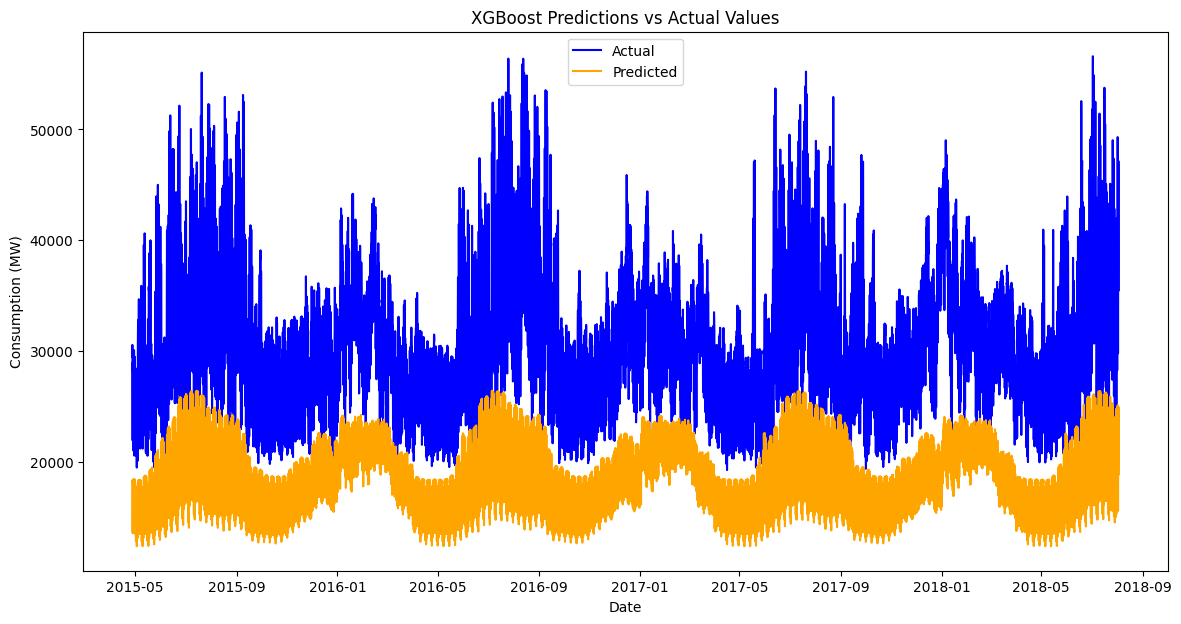

In [51]:
## plotting the predictions vs actual values graph
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual', color='blue')   
plt.plot(y_test.index, perdictions_xgb, label='Predicted', color='orange')
plt.title('XGBoost Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Consumption (MW)')  
plt.legend()
plt.show()

      Feature  Importance
0     PJMW_MW    0.402086
1        hour    0.144927
2   dayofweek    0.063938
3     quarter    0.138365
4       month    0.025322
5        year    0.128781
6   dayofyear    0.014509
7  dayofmonth    0.081438
8  weekofyear    0.000634


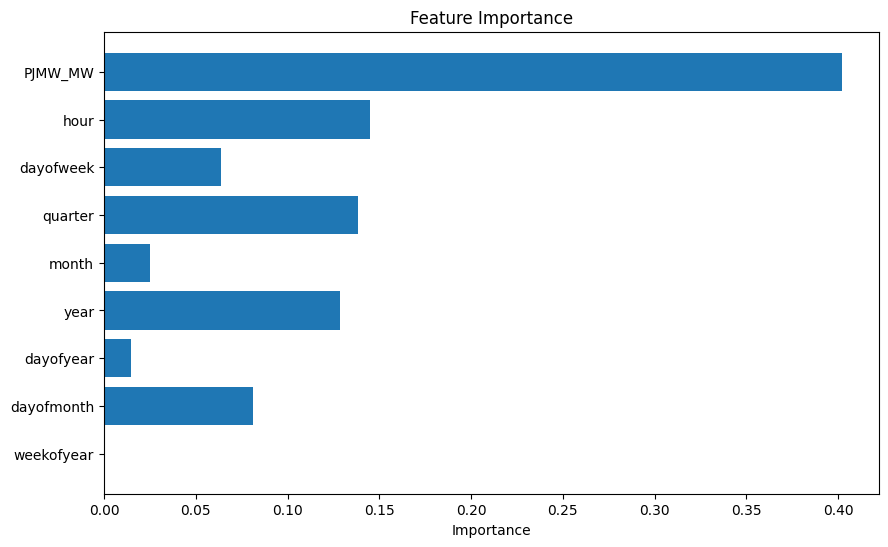

In [65]:
## Feature Importance
importances = model.feature_importances_
feature_names = X_train.drop(columns=['is_holiday'], axis=1).columns  # Exclude 'is_holiday' if it's not a feature
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  
plt.show()

In [68]:
## saving the model
import joblib

model_path = r'C:\Users\himan\Desktop\Projects\Energy_Forecasting_System\outputs\xgb_model.pkl'
joblib.dump(model, model_path)


['C:\\Users\\himan\\Desktop\\Projects\\Energy_Forecasting_System\\outputs\\xgb_model.pkl']